# ULS toyblocks demo

Notebook creator: Hannah Weiser, 2026

This demo uses a toy scene, which will be scanned by UAV-based laser scanning (ULS).

In [1]:
import helios
import numpy as np
import matplotlib.pyplot as plt

## Creating the virtual scene

In [2]:
# load objs and create transformations
groundplane = helios.ScenePart.from_obj(
    "../data/sceneparts/basic/groundplane/groundplane.obj"
).scale(80)

parts = helios.ScenePart.from_objs("../data/sceneparts/toyblocks/*.obj")
parts = [p.translate([-40.0, 0, 0]) for p in parts]
#scene
scene = helios.StaticScene(scene_parts=[groundplane] + parts)

## Platform and Scanner

In [3]:
scanner = helios.scanner_from_name("riegl_vux_1uav22")
platform = helios.platform_from_name("quadcopter")

## Scanner and platform settings

In [4]:
# these scanner settings will be shared between all legs
scanner_settings = helios.ScannerSettings(pulse_frequency="50 kHz",
                                          scan_frequency="25 Hz",
                                          scan_angle="90 deg",
                                          head_rotation="0 deg/s",
                                          trajectory_time_interval="0.05 s"
                                         )
z = 80.0

## Survey Route

In [5]:
survey = helios.Survey(scanner=scanner, platform=platform, scene=scene)

In [6]:
waypoints = [
    [-70, -60, 10],
    [70, -60, 10],
    [70.0, 60.0, 7],
    [-70.0, 60.0, 10],
    [0.0, -60.0, 4],
    [0.0, 60.0, 10]
]
for x, y, speed in waypoints:
    survey.add_leg(x=x, y=y, z=z, speed_m_s=speed, scanner_settings=scanner_settings)

## Executing the survey

In [7]:
points, trajectories = survey.run(verbosity=helios.LogVerbosity.VERBOSE, format=helios.OutputFormat.NPY)

## Visualizing the results

### Color by Object ID

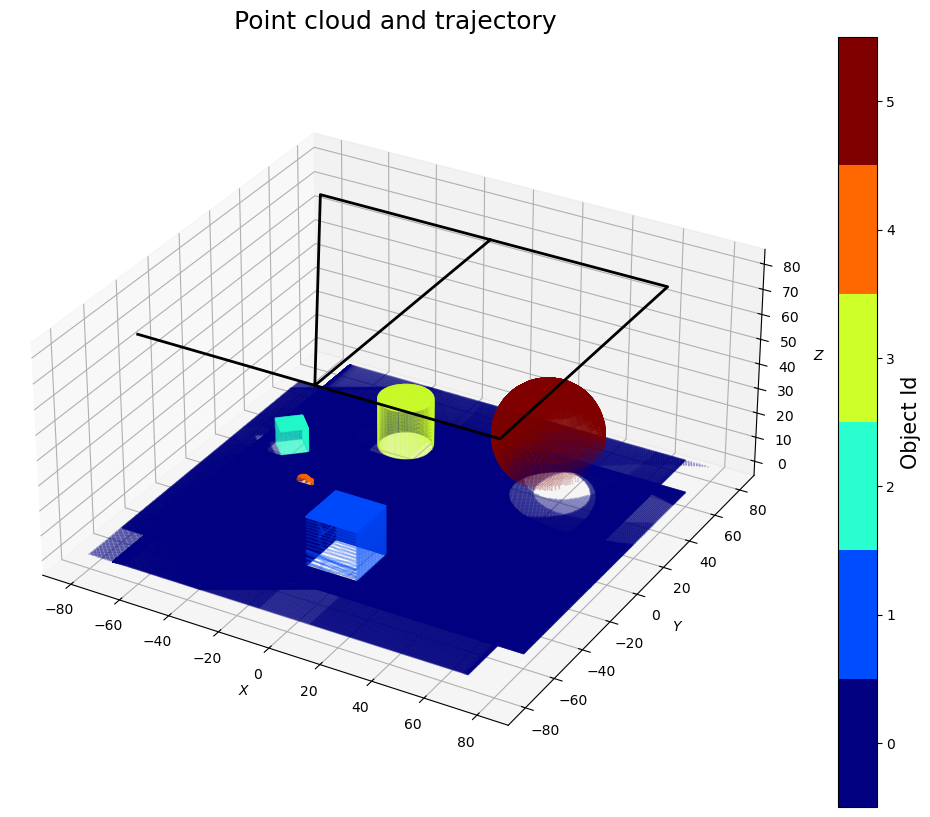

In [8]:
fig = plt.figure(figsize=(15, 10))
# 3d plot
ax = fig.add_subplot(projection="3d", computed_zorder=False)

# settings for a discrete colorbar
N = 6
cmap = plt.get_cmap("jet", N)

# scatter plot of points
pos = points["position"]
sc = ax.scatter(
    pos[:, 0],
    pos[:, 1],
    pos[:, 2],
    c=points["hit_object_id"],
    cmap=cmap,
    s=0.02,
    zorder=1,
    vmin=-0.5,
    vmax=N - 0.5
)

traj = trajectories["position"]
# Plot of trajectory
ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], c="black", linewidth=2, zorder=2)

# Add axis labels.
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.set_zlabel("$Z$")

# set equal axes
box = (
    np.ptp(np.hstack((pos[:, 0], traj[:, 0]))),
    np.ptp(np.hstack((pos[:, 1], traj[:, 1]))),
    np.ptp(np.hstack((pos[:, 2], traj[:, 2]))),
)
ax.set_box_aspect(box)

# Set title.
ax.set_title(label="Point cloud and trajectory", fontsize=18)

cbar = plt.colorbar(sc, ticks=[0, 1, 2, 3, 4, 5])
cbar.set_label("Object Id", fontsize=15)
cbar.ax.set_yticklabels(["0", "1", "2", "3", "4", "5"])

# Display results
plt.show()